# Neural Network
The final model to be tested will be a neural network, specifically: Keras's Sequential Model. The reason for<br/>
choosing Keras is that it is built on powerful foundations (in this example, the TensorFlow backend will be<br/>
used) however the Keras API is simple and intuitive, meaning the implementation can be built quickly.<br/><br/>
The methodology used is far more manual than was used in previous models. This is because of the long training<br/>
times associated with neural networks, so using random grid search isn't really practical. Therefore, the<br/>
single hyperparameters will be optimised one-by-one, with the following methodology:<br/>
1) Learning rate is one of the most important hyperparameters to ensure loss is smoothly reduced as the neural<br/>
network is trained. The approach used will be to start with an extremely low learning rate and then slowly<br/>
increase the learning rate each epoch. From looking at the visualisations of loss over epochs, it is possible to<br/>
select the highest possible learning rate where loss was reducing smoothly. This approach was popolarised by<br/>
Fast.AI<br/>
2) Next, model size will be increased until a point where the model is significantly overfitting the training<br/>
data. This is done by beginning with a neural network with a single layer of 1000 neurons, and then adding<br/>
additional hidden layers of 1000 neurons to see how cross validation and training accuracy changes.<br/>
3) Once we have a model that is significantly overfitting, dropout will be added in order to regularise the<br/>
model. Again, dropout will be slowly added until cross validation accuracy is maximised, which should be close<br/>
to the training accuracy.<br/>
4) Next, additional regularisation in the form of weight constraint will be experimented with to see if cross<br/>
validation accuracy can be improved further.<br/>
5) Finally, momentum will be added to the learning rate to see if any final improvements can be made to cross<br/>
validation accuracy.<br/><br/>
Once the above hyperparameters have been optimised, a final network will be trained on these parameters and saved<br/>
on AWS S3 to be tested in the next notebook along with the other models on the test set.

In [1]:
import os
import sys

import pandas as pd
import numpy as np

import random

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_auc_score
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras import backend as K

Using TensorFlow backend.


In [2]:
# Set up paths & import src functions
project_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
src_folder = os.path.join(project_root, 'src')
sys.path.insert(0, src_folder)
from stats_and_visualisations import *
from s3_storage import *

In [3]:
# Import data
X_train = from_s3(bucket='mimic-jamesi',
                  filepath='data/acute_kidney_failure_X_train.npy')
y_train = from_s3(bucket='mimic-jamesi',
                  filepath='data/acute_kidney_failure_y_train.npy')

Due to the long training times of neural networks, only a single cross validation set will be used for all<br/>
hyperparameter tuning (rather than needing to train each iteration multiple times, as was done with K Fold in<br/>
some of the previous models).

In [4]:
# Split into training and cross validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=8)

In [5]:
# Set options for Neural Network training
epochs=500
batch_size=100

In [6]:
def create_model(input_shape, neurons=1000, weight_constraint=3, dropout_rate=0.1,
                 hidden_layers=1, learn_rate=0.001, momentum=0.1):
    
    '''
    Function that creates a Neural Network using Keras's Sequential Model.
    
    Input shape must be the number of features in the training set.
    
    The remaining parameters are:
        1. neurons - the number of neurons in each layer excluding the
           input and output layer
        2. hidden_layers - the number of layers in the neural network,
           excluding the input and output layers
        3. learn_rate - the learning rate used by Stochastic Gradient Descent
        4. momentum - the proportion of the learning rate from step n-1 that
           is added to step n. Used to help the gradient descent algorithm move
           out of local minima or 'flat regions' towards the true global minimum
        5. dropout_rate - the proportion of neurons that are 'dropped' from each
           layer of the neural network. Used for regularisation to prevent
           overfitting
        6. weight_constraint - the maximum value for parameter weights in the
           neural network
    '''
        
    # Initialise the constructor
    model = Sequential()
    
    # Add an input layer
    model.add(Dense(neurons,
                    input_shape=input_shape,
                    activation='relu',
                    kernel_initializer = 'normal',
                    kernel_constraint=maxnorm(weight_constraint)))
    model.add(Dropout(dropout_rate))

    for i in range(hidden_layers):
        # Add one hidden layer
        model.add(Dense(neurons,
                        activation='relu',
                        kernel_initializer = 'normal',
                        kernel_constraint=maxnorm(weight_constraint)))
        model.add(Dropout(dropout_rate))

    # Add an output layer 
    model.add(Dense(1, kernel_initializer = 'normal', activation='sigmoid'))
    
    #compile model
    model.compile(loss='binary_crossentropy',
                  optimizer=SGD(lr=learn_rate, momentum=momentum),
                  metrics=['accuracy'])
    
    return model

In [7]:
def train_model(X_train, y_train, X_val, y_val, epochs, batch_size, params={},
                lr_inc=False, lr_multiplier=1, output_model=False):
    
    '''
    Function that trains a Neural Network for a specified number of epochs.
    
    It has the ability to increase the learning rate by a given multiplier
    each epoch so that the optimal learning rate can be selected. This is
    configured by the lr_inc parameter (which should be set to True if
    learning rate increasing is required), and the lr_multiplier
    parameter, which specifies the extent to which the learning rate increases
    each epoch.
    
    Other parameters:
        1. X_train, y_train, X_val, y_val - the training and cross validation
           feature and target variable numpy arrays
        2. epochs - the number of epochs to train the neural network for
        3. batch_size - determines the batch size of observations that are used
           for each step in the Stochastic Gradient Descent algorithm, and subsequent
           adjustments in the neural network parameter weights
        4. params - dict containing the hyperparameters that should be used in the
           create_model function
           
    The function outputs:
        1. train_score - final AUC score on the training set
        2. valid_score - final AUC score on the cross validation set
        3. model - the trained neural network
    '''
    
    print('------------')
    print('Params: ', params)
    
    model = create_model(**params, input_shape = (X_train.shape[1],))

    # Find the class weights so predictions match these weights
    class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)

    # Create a DataFrame that will store the model performance by epoch
    history = pd.DataFrame(columns=['epoch', 'lr', 'acc', 'loss', 'val_acc', 'val_loss'])
    
    # Train the model for the specifiec number of epochs, increaseing the learning
    # rate by the lr_multiplier if lr_inc == True
    for e in range(epochs):
        
        history_tmp = model.fit(X_train, y_train, epochs=1, batch_size=batch_size, verbose=0,
                                class_weight=class_weights, validation_data=(X_val, y_val))
        
        history.loc[e, 'epoch'] = e + 1
        history.loc[e, 'lr'] = round(K.get_value(model.optimizer.lr),5)
        history.loc[e, 'acc'] = history_tmp.history['acc'][0]
        history.loc[e, 'loss'] = history_tmp.history['loss'][0]
        history.loc[e, 'val_acc'] = history_tmp.history['val_acc'][0]
        history.loc[e, 'val_loss'] = history_tmp.history['val_loss'][0]
        
        # Raise the learning rate if needed
        if lr_inc:
            new_lr = lr_multiplier * K.get_value(model.optimizer.lr)
            K.set_value(model.optimizer.lr, new_lr)
        
    # Visualise loss by epoch
    if lr_inc:
        plot_loss_by_epoch(history, x_axis='lr')
    else:
        plot_loss_by_epoch(history)
    
    
    # Find the final training and cross validation AUC score
    train_predictions = model.predict(X_train)
    valid_predictions = model.predict(X_val)
    train_score = roc_auc_score(y_train, train_predictions)
    valid_score = roc_auc_score(y_val, valid_predictions)

    print('--> Training score: ', train_score)
    print('--> Valid score: ', valid_score)
        
    if output_model:
        return train_score, valid_score, model
    else:
        K.clear_session()
        return train_score, valid_score

In [8]:
def tune_neural_net_hyperparams(params, optimising_param, param_values, epochs, batch_size):
    
    '''
    Function that for a given hyperparameter, trains a neural network over a range
    of specified hyperparameter values. The output is a DataFrame showing the training
    and cross validation AUC score for the range of hyperparameter values, which
    enables the best hyperparameter value to be selected.
    
    Parameters:
        1. params - the fixed (non optimising) hyperparameters that should be used for
           all runs of the grid search
        2. optimising_param - the hyperparameter that should be optimised
        3. param_values - the specific range of values that should be used for the
           optimising hyperparameter
        4. epochs - the number of epochs for each optimising hyperparameter value
        5. batch_size - determines the batch size of observations that are used
           for each step in the Stochastic Gradient Descent algorithm, and subsequent
           adjustments in the neural network parameter weights
    '''
    
    # Create the output results DF
    results_df = pd.DataFrame(columns=[optimising_param, 'train_score', 'valid_score'])
    
    # Iterate through the values of the optimising hyperparameter
    for ix,v in enumerate(param_values):
    
        # Update the params dictionary to include the parameter value, then train the model
        params.update({optimising_param : v})
        
        train_score, valid_score = train_model(X_train, y_train, X_val, y_val,
                                               params=params, epochs=epochs,
                                               batch_size=batch_size)

        results_df.loc[ix, optimising_param] = v
        results_df.loc[ix, 'train_score'] = train_score
        results_df.loc[ix, 'valid_score'] = valid_score

    plot_neural_net_hyperparam(results_df, optimising_param, 'train_score', 'valid_score')
    
    return results_df

## Learning Rate
The learning rate is arguably the most important hyperparameter for neural networks, so will be optimised first.<br/>
We'll start with a learning rate of 0.00000001 and then increase it by 10% each epoch for 210 epochs. The purpose<br/>
of doing this is to find the largest learning rate where the loss is still steadily declining, as this is the<br/>
learning rate that strikes the correct balance between model accuracy and fast training time.<br/><br/>
From looking at the loss graph below, the optimal learning rate looks to be around 0.04, so this learning rate<br/>
will be selected and used when tuning the remaining hyperparameters.

------------
Params:  {'learn_rate': 1e-08, 'momentum': 0}


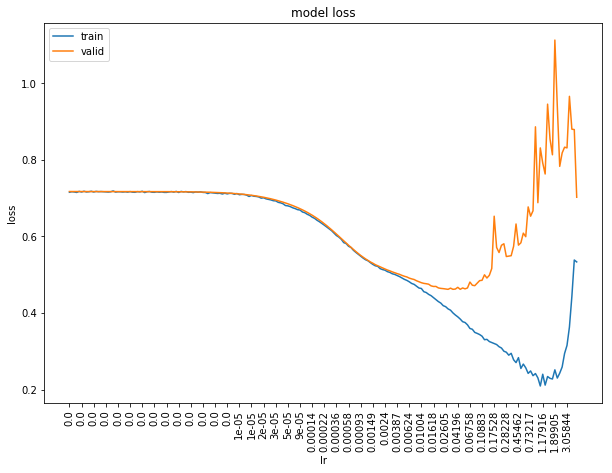

--> Training score:  0.9062782063716394
--> Valid score:  0.8444414517764809


<Figure size 432x288 with 0 Axes>

In [9]:
train_score, valid_score = train_model(X_train, y_train, X_val, y_val,
                                       params={'learn_rate':0.00000001, 'momentum':0},
                                       epochs=210, batch_size=batch_size,
                                       lr_inc = True, lr_multiplier=1.1)

## Hidden Layers
Next, hidden layers will be added until significant overfitting takes place. The reason to do this is so that we<br/>
know we're building a model with enough complexity to capture the differences between positive and negative<br/>
patients, and later we can add regularisation to ensure the model generalises for unseen test cases.<br/><br/>

From looking at the loss curves AUC scores for the training and cross validation scores, the iteration with 1<br/>
hidden layer looks to be the one that is very well fitted to the training data while having a lower training<br/>
time than models with a greater number of layers.

------------
Params:  {'learn_rate': 0.04, 'hidden_layers': 0}


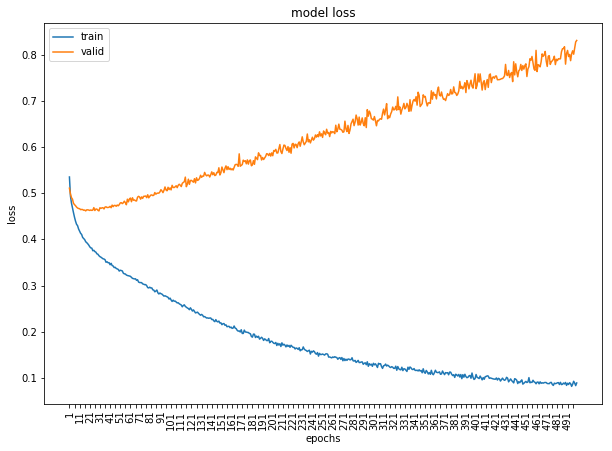

--> Training score:  0.9998684870622528
--> Valid score:  0.8468409064458743
------------
Params:  {'learn_rate': 0.04, 'hidden_layers': 1}


<Figure size 432x288 with 0 Axes>

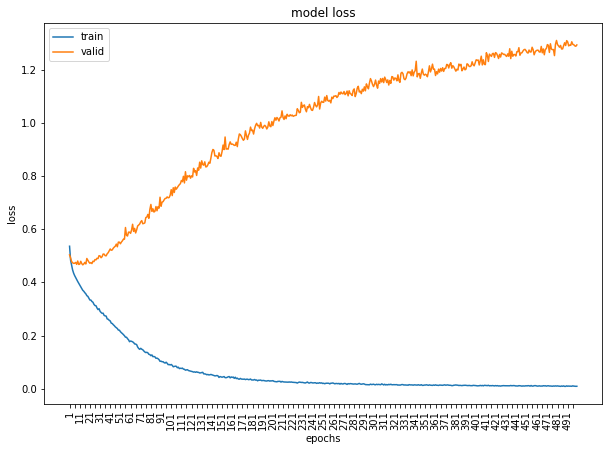

--> Training score:  0.9999903802097854
--> Valid score:  0.8278062081234309
------------
Params:  {'learn_rate': 0.04, 'hidden_layers': 2}


<Figure size 432x288 with 0 Axes>

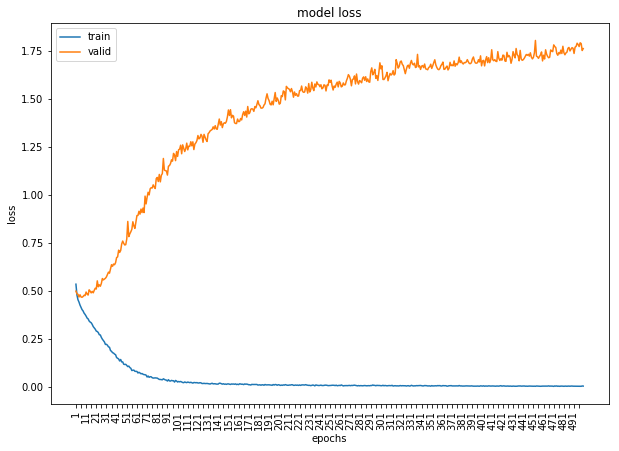

--> Training score:  0.9999904226812654
--> Valid score:  0.8233484629324819


<Figure size 432x288 with 0 Axes>

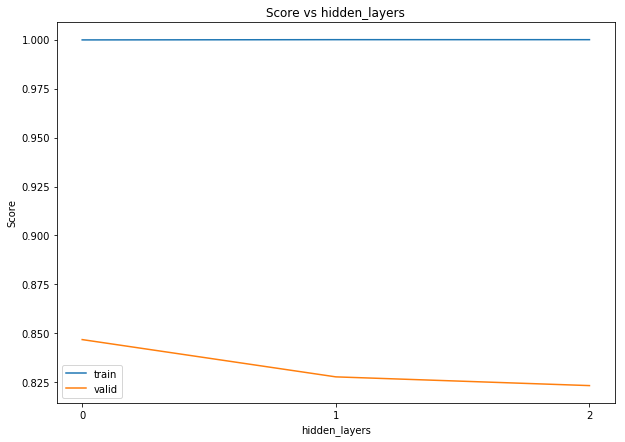

,hidden_layers,train_score,valid_score
0,0,0.999868,0.846841
1,1,0.99999,0.827806
2,2,0.99999,0.823348


<Figure size 432x288 with 0 Axes>

In [10]:
tune_neural_net_hyperparams(params = {'learn_rate': 0.04},
                            optimising_param = 'hidden_layers',
                            param_values = [0,1,2],
                            epochs = epochs,
                            batch_size = batch_size)

## Dropout
Since the model is overfitting to such a large extent, regulariation is of critical importance, and dropout has<br/>
been shown to be an effective regularisation technique.<br/><br/>

On the overfitting models, the loss curve for the cross validation set increases as we train over more and more<br/>
epochs. What we're looking for is a dropout rate that produces a cross validation loss curve that improves over<br/>
time, giving the best possible cross validation score.<br/><br/>

From looking at the results below, a dropout of 0.92 produces the best results.

------------
Params:  {'learn_rate': 0.04, 'hidden_layers': 1, 'dropout_rate': 0.25}


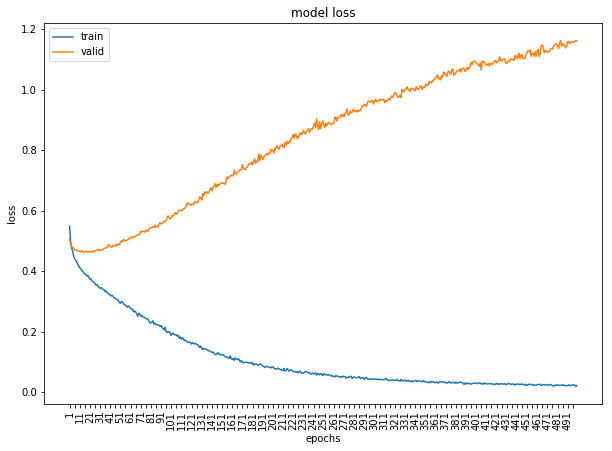

--> Training score:  0.9999902527953454
--> Valid score:  0.8248431343209138
------------
Params:  {'learn_rate': 0.04, 'hidden_layers': 1, 'dropout_rate': 0.5}


<Figure size 432x288 with 0 Axes>

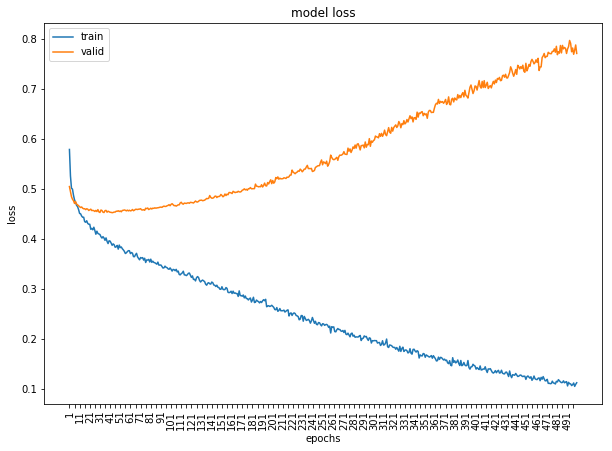

--> Training score:  0.9999005955011151
--> Valid score:  0.8301764011505147
------------
Params:  {'learn_rate': 0.04, 'hidden_layers': 1, 'dropout_rate': 0.75}


<Figure size 432x288 with 0 Axes>

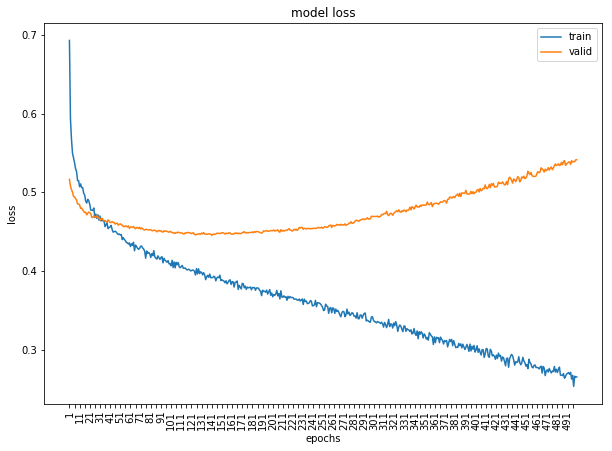

--> Training score:  0.9850667940471294
--> Valid score:  0.8466719869652684
------------
Params:  {'learn_rate': 0.04, 'hidden_layers': 1, 'dropout_rate': 0.8}


<Figure size 432x288 with 0 Axes>

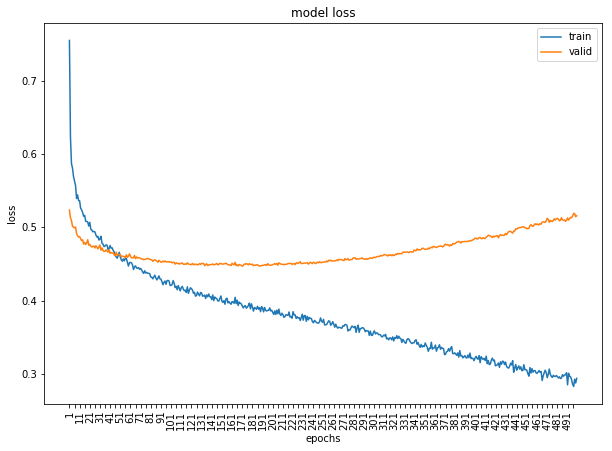

--> Training score:  0.9768699258261084
--> Valid score:  0.8518094003025919
------------
Params:  {'learn_rate': 0.04, 'hidden_layers': 1, 'dropout_rate': 0.82}


<Figure size 432x288 with 0 Axes>

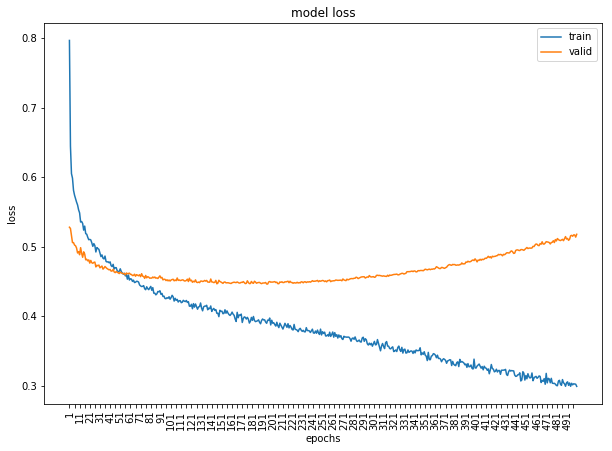

--> Training score:  0.9706423327171573
--> Valid score:  0.8583247709777713
------------
Params:  {'learn_rate': 0.04, 'hidden_layers': 1, 'dropout_rate': 0.84}


<Figure size 432x288 with 0 Axes>

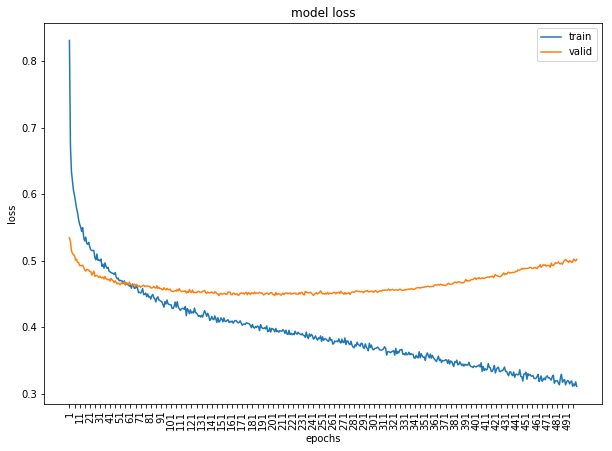

--> Training score:  0.9649159030719281
--> Valid score:  0.8591351189585517
------------
Params:  {'learn_rate': 0.04, 'hidden_layers': 1, 'dropout_rate': 0.86}


<Figure size 432x288 with 0 Axes>

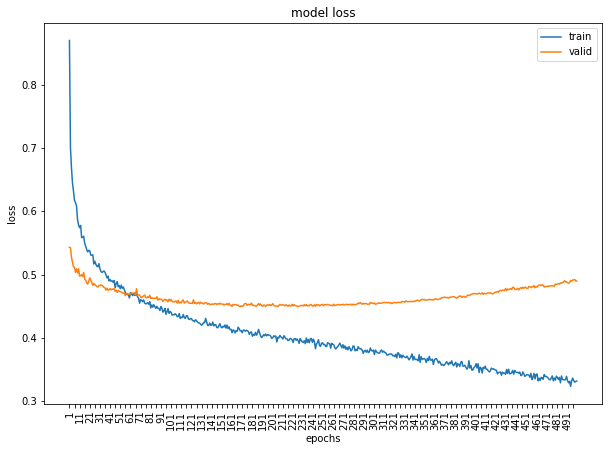

--> Training score:  0.9564424818090403
--> Valid score:  0.8630864382263453
------------
Params:  {'learn_rate': 0.04, 'hidden_layers': 1, 'dropout_rate': 0.88}


<Figure size 432x288 with 0 Axes>

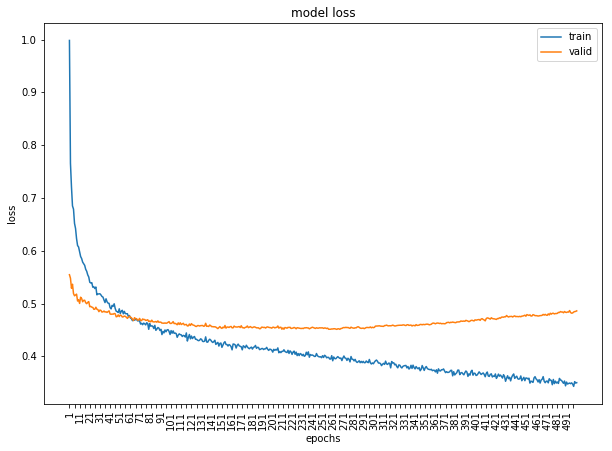

--> Training score:  0.9467119472103287
--> Valid score:  0.8649159559080254
------------
Params:  {'learn_rate': 0.04, 'hidden_layers': 1, 'dropout_rate': 0.9}


<Figure size 432x288 with 0 Axes>

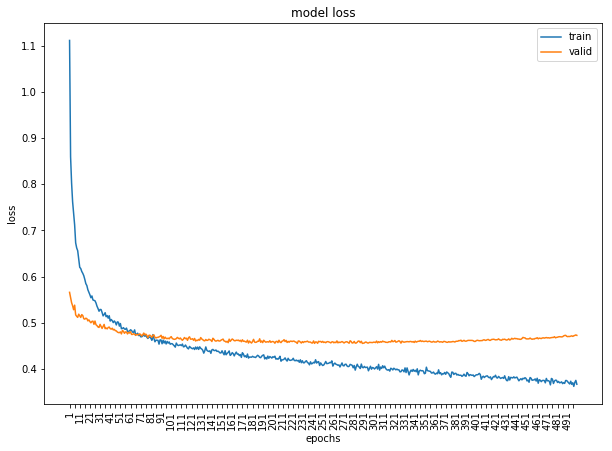

--> Training score:  0.9393788214775896
--> Valid score:  0.864379935823898
------------
Params:  {'learn_rate': 0.04, 'hidden_layers': 1, 'dropout_rate': 0.92}


<Figure size 432x288 with 0 Axes>

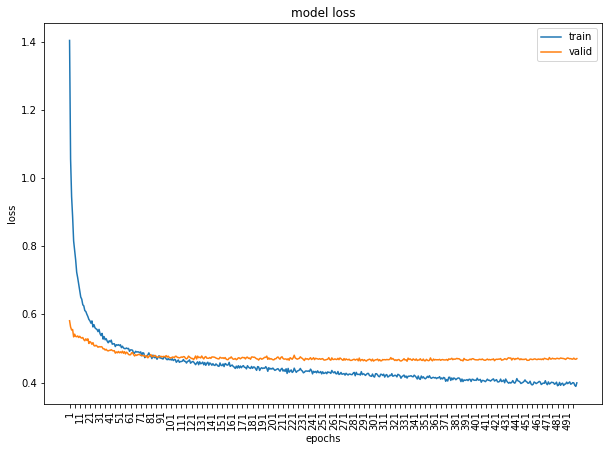

--> Training score:  0.929579589260016
--> Valid score:  0.8666197815352388
------------
Params:  {'learn_rate': 0.04, 'hidden_layers': 1, 'dropout_rate': 0.94}


<Figure size 432x288 with 0 Axes>

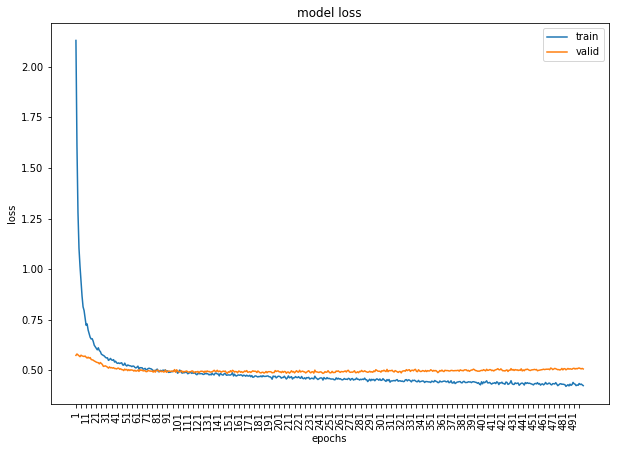

--> Training score:  0.9162803885562806
--> Valid score:  0.8653236237883851
------------
Params:  {'learn_rate': 0.04, 'hidden_layers': 1, 'dropout_rate': 0.96}


<Figure size 432x288 with 0 Axes>

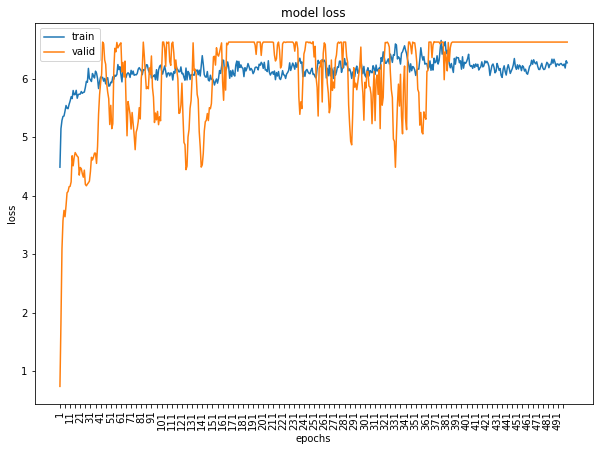

--> Training score:  0.5
--> Valid score:  0.5
------------
Params:  {'learn_rate': 0.04, 'hidden_layers': 1, 'dropout_rate': 0.98}


<Figure size 432x288 with 0 Axes>

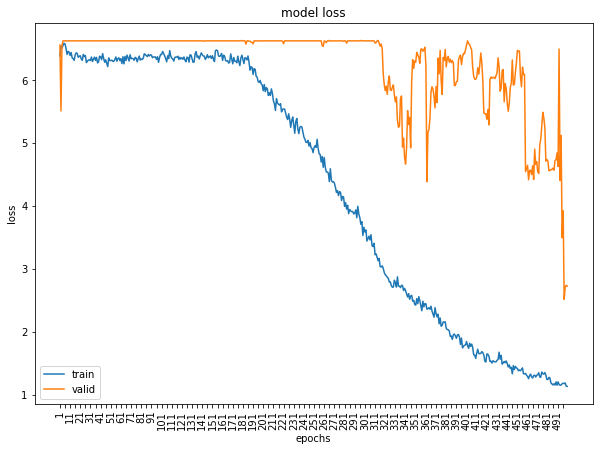

--> Training score:  0.5083544374117336
--> Valid score:  0.5158388614560993


<Figure size 432x288 with 0 Axes>

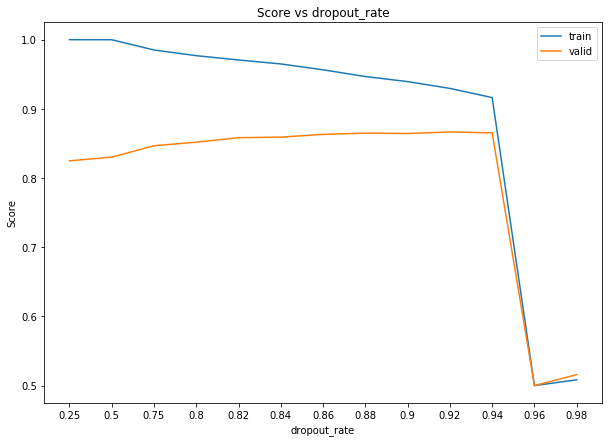

,dropout_rate,train_score,valid_score
0,0.25,0.99999,0.824843
1,0.5,0.999901,0.830176
2,0.75,0.985067,0.846672
3,0.8,0.97687,0.851809
4,0.82,0.970642,0.858325
5,0.84,0.964916,0.859135
6,0.86,0.956442,0.863086
7,0.88,0.946712,0.864916
8,0.9,0.939379,0.86438
9,0.92,0.92958,0.86662


<Figure size 432x288 with 0 Axes>

In [11]:
tune_neural_net_hyperparams(params = {'learn_rate': 0.04, 'hidden_layers': 1},
                            optimising_param = 'dropout_rate',
                            param_values = [0.25, 0.5, 0.75, 0.80, 0.82, 0.84, 0.86,
                                            0.88, 0.90, 0.92, 0.94, 0.96, 0.98],
                            epochs = epochs,
                            batch_size = batch_size)

## Weight constraint
As additional regularisation, weight constraint will be tuned. As the results below show, a weight constraint<br/>
of 1 gives the best cross validation accuracy.

------------
Params:  {'learn_rate': 0.04, 'hidden_layers': 1, 'dropout_rate': 0.92, 'weight_constraint': 0.001}


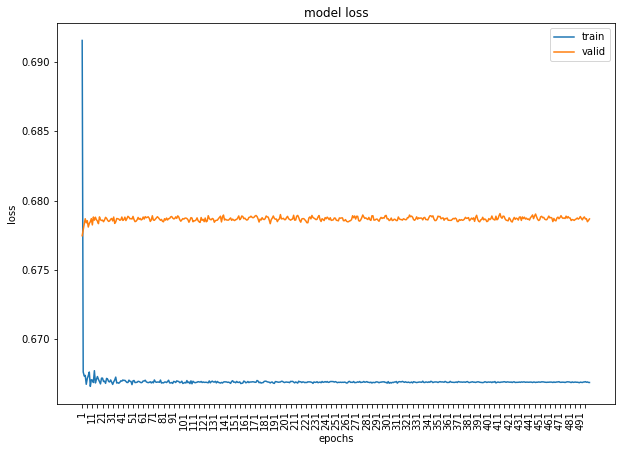

--> Training score:  0.8235881673097698
--> Valid score:  0.8208000399022396
------------
Params:  {'learn_rate': 0.04, 'hidden_layers': 1, 'dropout_rate': 0.92, 'weight_constraint': 0.01}


<Figure size 432x288 with 0 Axes>

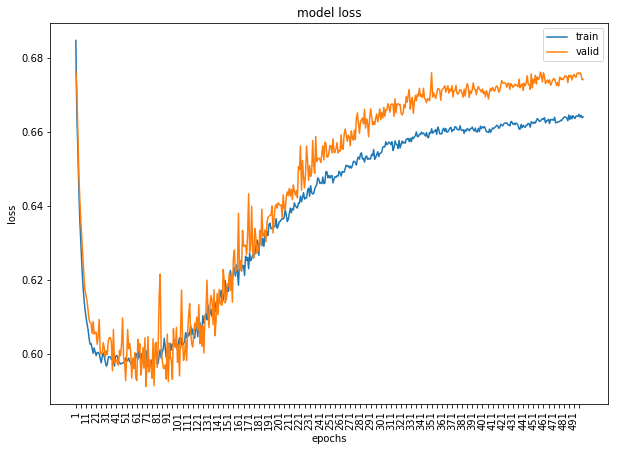

--> Training score:  0.8248068227204749
--> Valid score:  0.8221597087136515
------------
Params:  {'learn_rate': 0.04, 'hidden_layers': 1, 'dropout_rate': 0.92, 'weight_constraint': 0.05}


<Figure size 432x288 with 0 Axes>

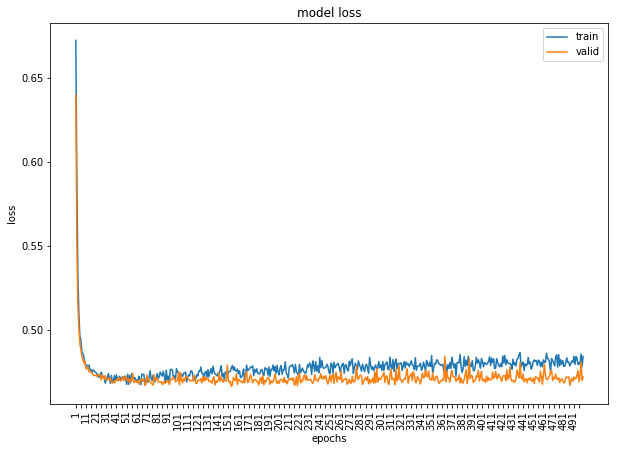

--> Training score:  0.8680432352870724
--> Valid score:  0.8546358089347765
------------
Params:  {'learn_rate': 0.04, 'hidden_layers': 1, 'dropout_rate': 0.92, 'weight_constraint': 0.1}


<Figure size 432x288 with 0 Axes>

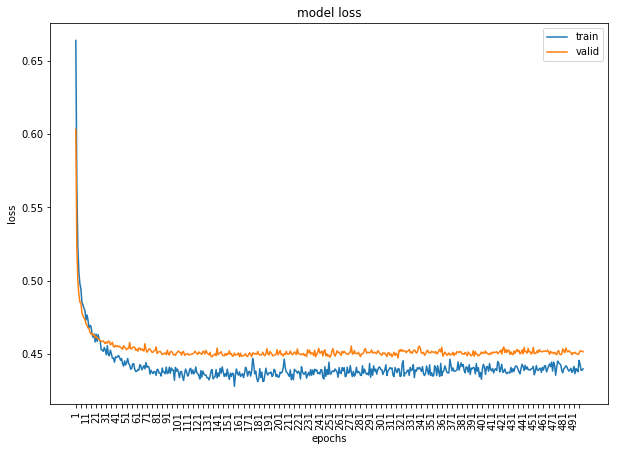

--> Training score:  0.8971462435759764
--> Valid score:  0.8647450413154439
------------
Params:  {'learn_rate': 0.04, 'hidden_layers': 1, 'dropout_rate': 0.92, 'weight_constraint': 0.25}


<Figure size 432x288 with 0 Axes>

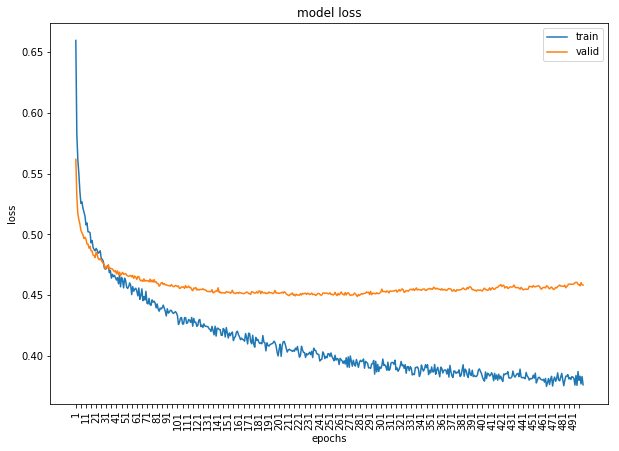

--> Training score:  0.9382627983982476
--> Valid score:  0.8618887060036245
------------
Params:  {'learn_rate': 0.04, 'hidden_layers': 1, 'dropout_rate': 0.92, 'weight_constraint': 0.5}


<Figure size 432x288 with 0 Axes>

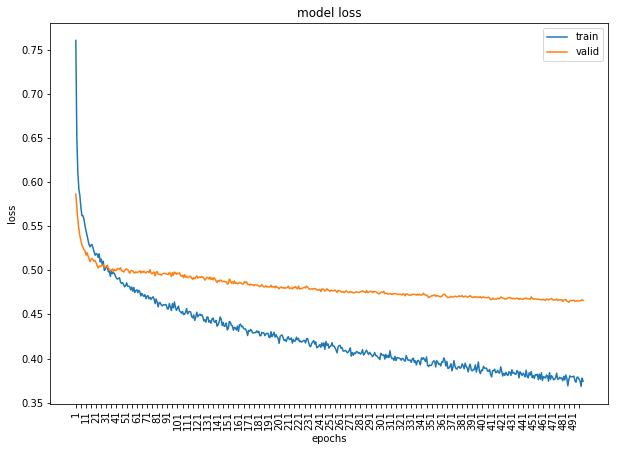

--> Training score:  0.9358402251803891
--> Valid score:  0.8619801486358423
------------
Params:  {'learn_rate': 0.04, 'hidden_layers': 1, 'dropout_rate': 0.92, 'weight_constraint': 1}


<Figure size 432x288 with 0 Axes>

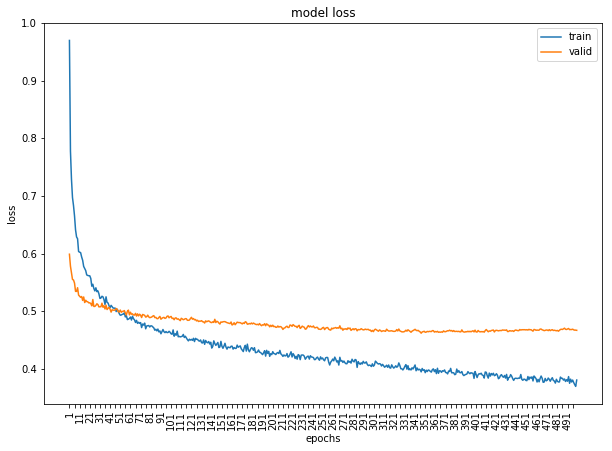

--> Training score:  0.9327424403738644
--> Valid score:  0.8680150298435498
------------
Params:  {'learn_rate': 0.04, 'hidden_layers': 1, 'dropout_rate': 0.92, 'weight_constraint': 1.5}


<Figure size 432x288 with 0 Axes>

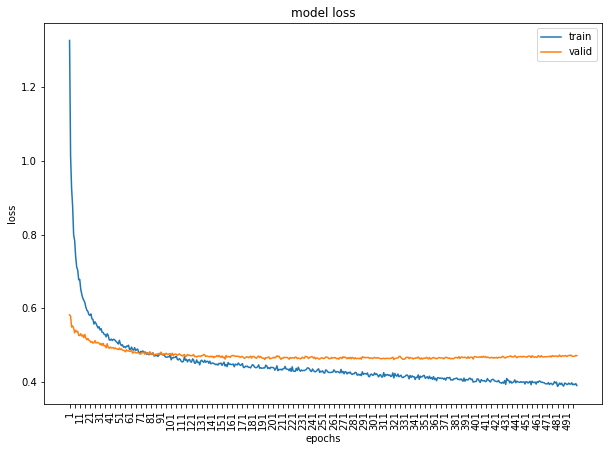

--> Training score:  0.9298911600371236
--> Valid score:  0.8661821869752441
------------
Params:  {'learn_rate': 0.04, 'hidden_layers': 1, 'dropout_rate': 0.92, 'weight_constraint': 2}


<Figure size 432x288 with 0 Axes>

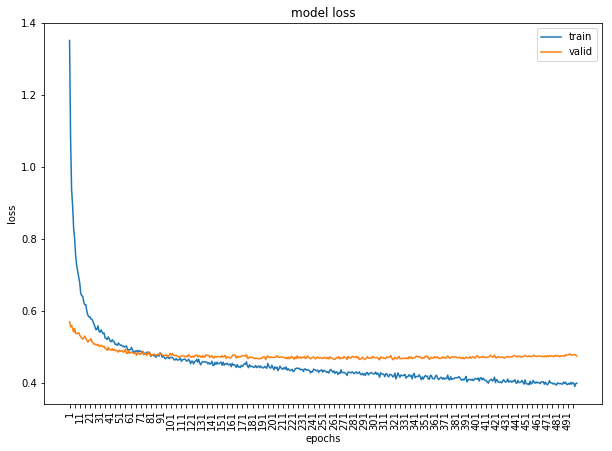

--> Training score:  0.9288935899154358
--> Valid score:  0.8651287678520958
------------
Params:  {'learn_rate': 0.04, 'hidden_layers': 1, 'dropout_rate': 0.92, 'weight_constraint': 2.5}


<Figure size 432x288 with 0 Axes>

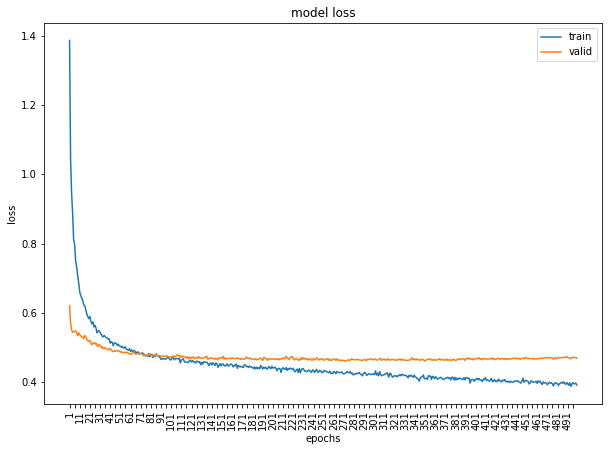

--> Training score:  0.9286794062419146
--> Valid score:  0.8650961810231601
------------
Params:  {'learn_rate': 0.04, 'hidden_layers': 1, 'dropout_rate': 0.92, 'weight_constraint': 3}


<Figure size 432x288 with 0 Axes>

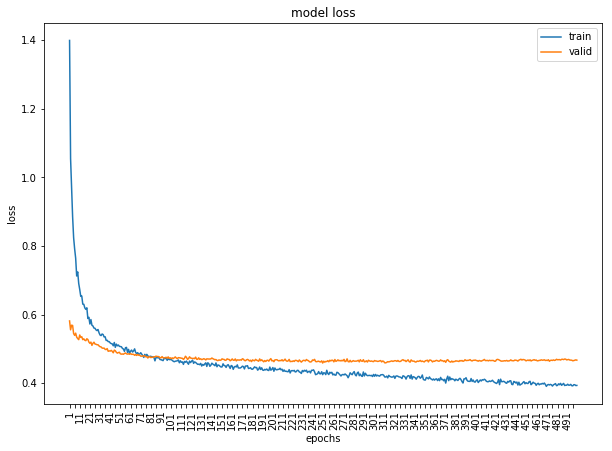

--> Training score:  0.9284174421534196
--> Valid score:  0.8668186276954795


<Figure size 432x288 with 0 Axes>

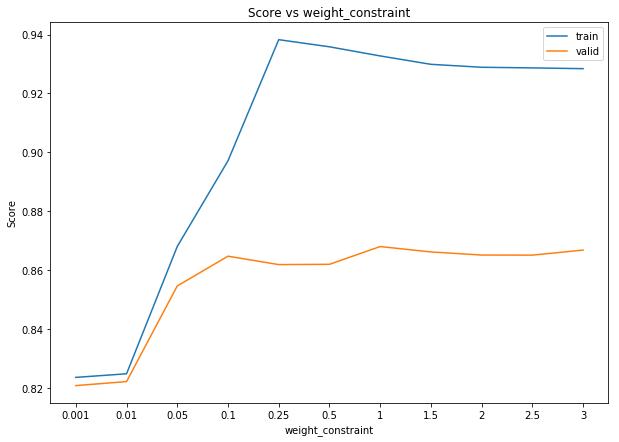

,weight_constraint,train_score,valid_score
0,0.001,0.823588,0.8208
1,0.01,0.824807,0.82216
2,0.05,0.868043,0.854636
3,0.1,0.897146,0.864745
4,0.25,0.938263,0.861889
5,0.5,0.93584,0.86198
6,1,0.932742,0.868015
7,1.5,0.929891,0.866182
8,2,0.928894,0.865129
9,2.5,0.928679,0.865096


<Figure size 432x288 with 0 Axes>

In [12]:
tune_neural_net_hyperparams(params = {'learn_rate': 0.04, 'hidden_layers': 1,
                                      'dropout_rate': 0.92},
                            optimising_param = 'weight_constraint',
                            param_values = [0.001, 0.01, 0.05, 0.1, 0.25, 0.5, 1, 1.5, 2, 2.5, 3],
                            epochs = epochs,
                            batch_size = batch_size)

## Momentum
Learning rate momentum is the final hyperparameter to be optimised. As the results below show, the best cross<br/>
validation accuracy is achieved with lower momentum, so a momentum of 0.1 will be chosen.

------------
Params:  {'learn_rate': 0.04, 'hidden_layers': 1, 'dropout_rate': 0.92, 'weight_constraint': 1, 'momentum': 0.1}


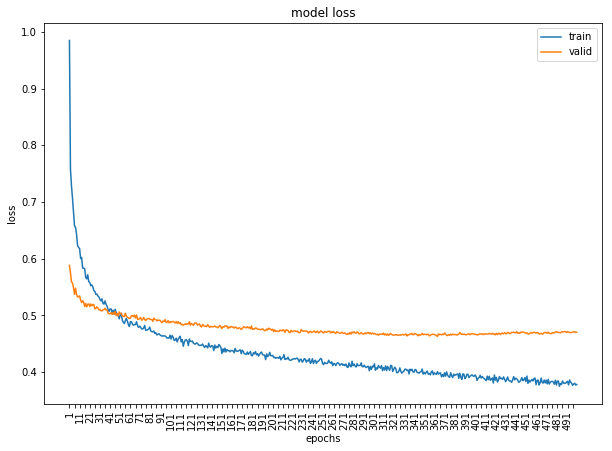

--> Training score:  0.933068600104344
--> Valid score:  0.8674743544981462
------------
Params:  {'learn_rate': 0.04, 'hidden_layers': 1, 'dropout_rate': 0.92, 'weight_constraint': 1, 'momentum': 0.2}


<Figure size 432x288 with 0 Axes>

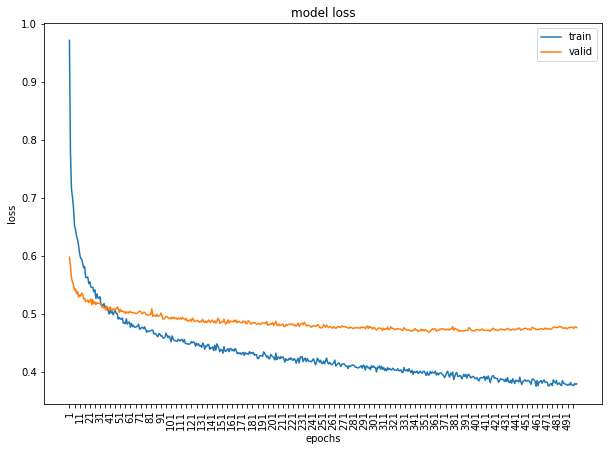

--> Training score:  0.9342082797980328
--> Valid score:  0.8668588624536551
------------
Params:  {'learn_rate': 0.04, 'hidden_layers': 1, 'dropout_rate': 0.92, 'weight_constraint': 1, 'momentum': 0.3}


<Figure size 432x288 with 0 Axes>

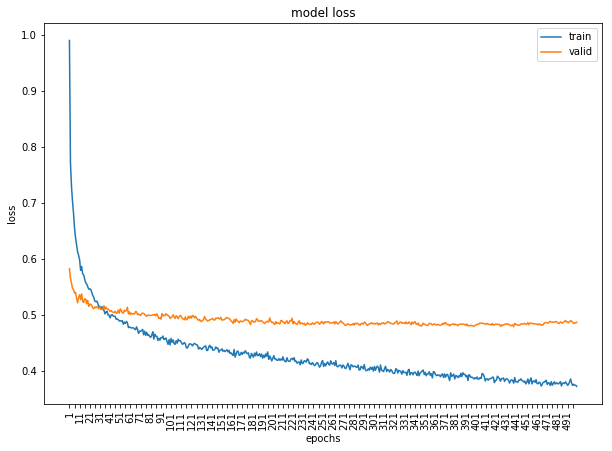

--> Training score:  0.9347832162224745
--> Valid score:  0.8653222937137346
------------
Params:  {'learn_rate': 0.04, 'hidden_layers': 1, 'dropout_rate': 0.92, 'weight_constraint': 1, 'momentum': 0.4}


<Figure size 432x288 with 0 Axes>

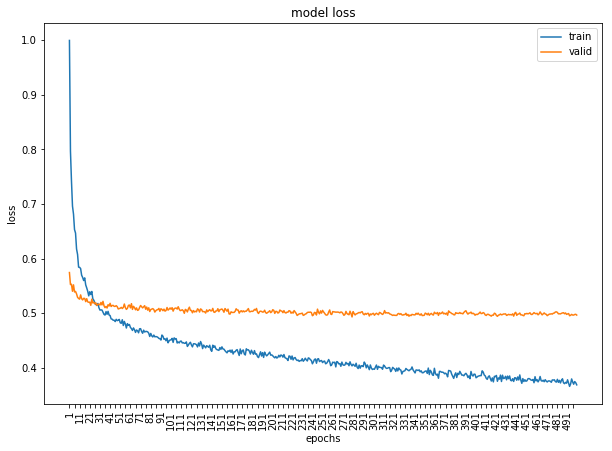

--> Training score:  0.9355006019907571
--> Valid score:  0.8636101551199562
------------
Params:  {'learn_rate': 0.04, 'hidden_layers': 1, 'dropout_rate': 0.92, 'weight_constraint': 1, 'momentum': 0.5}


<Figure size 432x288 with 0 Axes>

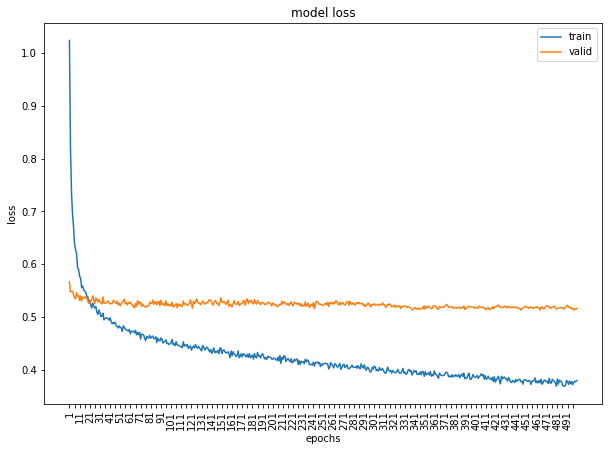

--> Training score:  0.9333696591901571
--> Valid score:  0.8621906329492742
------------
Params:  {'learn_rate': 0.04, 'hidden_layers': 1, 'dropout_rate': 0.92, 'weight_constraint': 1, 'momentum': 0.6}


<Figure size 432x288 with 0 Axes>

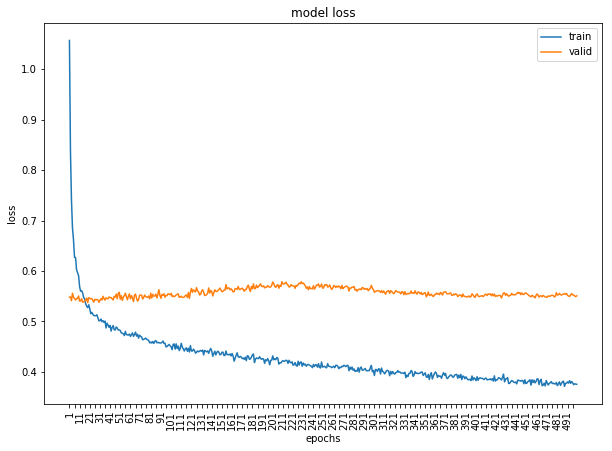

--> Training score:  0.9310941010002374
--> Valid score:  0.8573874008678737
------------
Params:  {'learn_rate': 0.04, 'hidden_layers': 1, 'dropout_rate': 0.92, 'weight_constraint': 1, 'momentum': 0.7}


<Figure size 432x288 with 0 Axes>

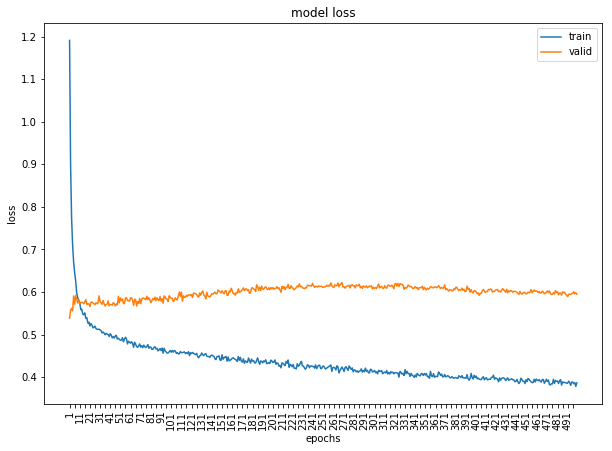

--> Training score:  0.9261007078636624
--> Valid score:  0.8511217517083147
------------
Params:  {'learn_rate': 0.04, 'hidden_layers': 1, 'dropout_rate': 0.92, 'weight_constraint': 1, 'momentum': 0.8}


<Figure size 432x288 with 0 Axes>

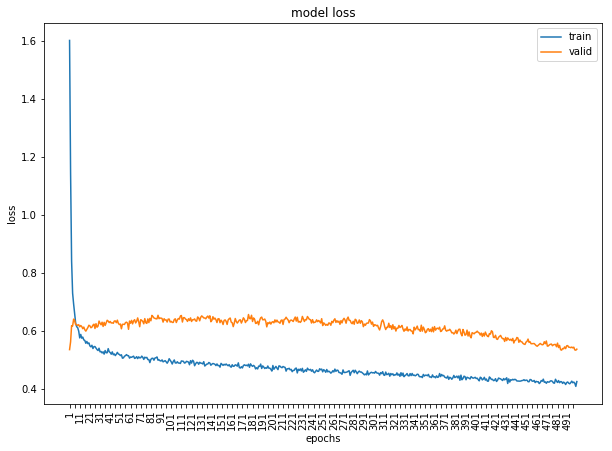

--> Training score:  0.8993257100424494
--> Valid score:  0.8307835802284402
------------
Params:  {'learn_rate': 0.04, 'hidden_layers': 1, 'dropout_rate': 0.92, 'weight_constraint': 1, 'momentum': 0.9}


<Figure size 432x288 with 0 Axes>

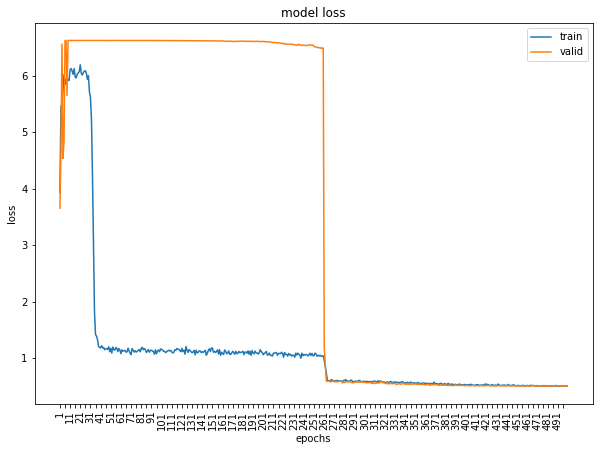

--> Training score:  0.8594218646236866
--> Valid score:  0.826369727500956


<Figure size 432x288 with 0 Axes>

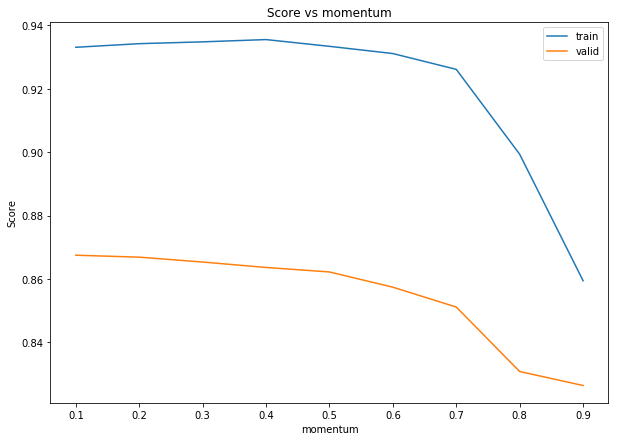

,momentum,train_score,valid_score
0,0.1,0.933069,0.867474
1,0.2,0.934208,0.866859
2,0.3,0.934783,0.865322
3,0.4,0.935501,0.86361
4,0.5,0.93337,0.862191
5,0.6,0.931094,0.857387
6,0.7,0.926101,0.851122
7,0.8,0.899326,0.830784
8,0.9,0.859422,0.82637


<Figure size 432x288 with 0 Axes>

In [13]:
tune_neural_net_hyperparams(params = {'learn_rate': 0.04, 'hidden_layers': 1,
                                      'dropout_rate': 0.92, 'weight_constraint': 1},
                            optimising_param = 'momentum',
                            param_values = [0.1, 0.2, 0.3, 0.4, 0.5,
                                            0.6, 0.7, 0.8, 0.9],
                            epochs = epochs,
                            batch_size = batch_size)

## Final training run
A final training run will be performed on the full training set using the optimised hyperparameters found above.<br/>
The trained model will then be saved on S3.

------------
Params:  {'learn_rate': 0.04, 'hidden_layers': 1, 'dropout_rate': 0.92, 'weight_constraint': 1, 'momentum': 0.1}


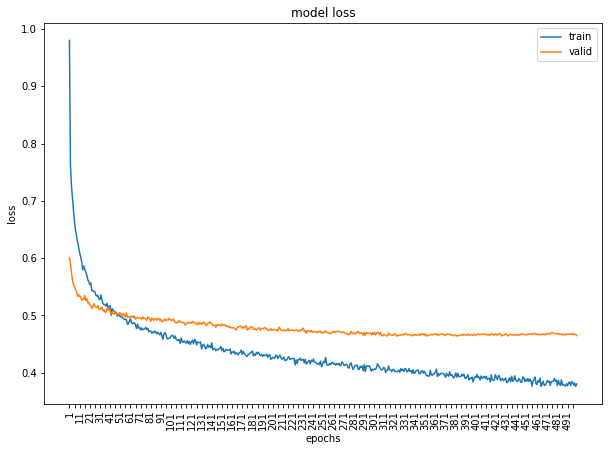

--> Training score:  0.9331895801150569
--> Valid score:  0.8689972899728997


<Figure size 432x288 with 0 Axes>

In [14]:
params = {}
params['learn_rate'] = 0.04
params['hidden_layers'] = 1
params['dropout_rate'] = 0.92
params['weight_constraint'] = 1 
params['momentum'] = 0.1
    
train_score, valid_score, model = train_model(X_train, y_train, X_val, y_val,
                                              params=params, epochs=epochs,
                                              batch_size=batch_size,
                                              output_model=True)

In [15]:
# Save model as Pickle
to_s3(obj=model, bucket='mimic-jamesi', filepath='models/neural_network')